<a href="https://colab.research.google.com/github/SamShelby/Deep_Learning/blob/master/src/tareas/t2/notebooks/ej1_utk_faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2: redes convolucionales, recurrentes y transferencia

Curso: [Aprendizaje Profundo](http://turing.iimas.unam.mx/~gibranfp/cursos/aprendizaje_profundo/). Profesor: [Gibran Fuentes Pineda](http://turing.iimas.unam.mx/~gibranfp/). Ayudantes: [Bere](https://turing.iimas.unam.mx/~bereml/) y [Ricardo](https://turing.iimas.unam.mx/~ricardoml/).
Alumno: [Samuel López](https://github.com/SamShelby)
---
---

## 0 Preparación

In [1]:
# Colab
! pip install torchinfo

### 0.1 Bibliotecas

In [2]:
# marcas de tiempo
import datetime
# explorar el sistema de archivos
import glob
# sistema de archivos
import os
# funciones aleatorias
import random
# marcas de tiempo
import time
# tomar n elementos de una secuencia
from itertools import islice as take
# sistema de archivos
from os.path import join

# gráficas
import matplotlib.patches as patches
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# csv
import pandas as pd
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets.utils as tvu
import torchvision.models as tvm
import torchvision.transforms as T
# leer archivo matlab
from scipy.io import loadmat
# cargador de datos
from torch.utils.data import DataLoader
# trazas de Tensorboard
from torch.utils.tensorboard import SummaryWriter
# inspección de arquitectura
from torchinfo import summary
# barra de progreso
from tqdm import tqdm
# imágenes
from PIL import Image

### 0.2 Auxiliares

In [3]:
# directorio de datos
DATA_DIR = os.path.join('..', 'data')

# tamaño del lote
BATCH_SIZE = 32
# tamaño de la imagen
IMG_SIZE = 224

# filas y columnas de la cuadrícula 
ROWS, COLS = 4, 8


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Despliega un ejempos en una cuadrícula."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Despliega un lote en una cuadrícula."""
    # denormalizamos
    for c, (mean, std) in enumerate(zip(IMAGENET_MEAN, IMAGENET_STD)):
        x[:, c] = x[:, c] * std + mean 
    x *= 255
    # rotamos canales
    x = x.permute(0, 2, 3, 1)
    # convertimos a entero
    x = (x.numpy()).astype(np.uint8)
    # desplegamos lote
    display_grid(x, titles, rows, cols, figsize)


def timestamp(fmt='%y%m%dT%H%M%S'):
    """Regresa la marca de tiempo."""
    return datetime.datetime.fromtimestamp(time.time()).strftime(fmt)


def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


# reproducibilidad
set_seed()


In [4]:
# media y varianza de de ImageNet
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

## 1 Implementando la tubería de datos para la tarea objetivo.

### 1.1 Conjunto de datos
Las imagenes del dataset tienen la siguiente nomenclatura en el nombre: <br>
[edad] _ [genero] _ [etnia] _ [nombreimagen].jpg <br>
Se descargan las imagenes usando la clase UtkFaces que guarda en el atributo 'dataset' un diccionario
con el dataset de entrenamiento y de prueba y que son de tipo 'UtkFacesDataset'.


In [5]:
class UtkFaces:

    def __init__(self, root, dataset_name='utk_faces',
                 transforms=None, download=False):

        # guardamos atributos
        self.root = join(root, dataset_name)
        self.data_path = os.path.join(root, dataset_name, 'UTKFace')
        self.transforms = transforms

        # creamos directorio raíz
        os.makedirs(os.path.join(root, dataset_name, 'UTKFace'), exist_ok=True)

        # descargados datos
        if download:
            self.download()

        # verificamos integridad
        if not self._check_integrity():
            raise RuntimeError(
                'Dataset not found or corrupted.'
                ' You can use download=True to download it')

        photos = os.listdir(self.data_path)
        self.age = []
        self.gender = []
        self.ethnia = []
        self.data = []

        print('{} files found'.format(len(photos)))
        for photo in photos:
            name_splitted = photo.split('_')
            try:
                features = np.array(name_splitted[:3]).astype(int)
                self.age.append(int(features[0]))
                self.gender.append(int(features[1]))
                self.ethnia.append(int(features[2]))
                self.data.append(photo)

            except Exception as e:
                print('photo: {} has wrong format'.format(photo))

        self.age = np.array(self.age)
        self.gender = np.array(self.gender)
        self.ethnia = np.array(self.ethnia)
        self.data = np.array(self.data)

        train_test = np.random.choice([0, 1], len(self.age), p=[0.2, 0.8])

        self.datasets = [UtkFacesDataset(data_path=self.data_path,
                                         data=self.data[train_test == i],
                                         gender=self.gender[train_test == i],
                                         age=self.age[train_test == i],
                                         ethnia=self.ethnia[train_test == i],
                                         transform=transforms[i] if transforms is not None else None)
                         for i in range(2)]

        self.datasets = {'train': self.datasets[1],
                         'test': self.datasets[0]}

    def _check_integrity(self):
        return len(os.listdir(os.path.join(self.root, 'UTKFace'))) > 10000

    def download(self):
        if self._check_integrity():
            print('Files already downloaded and verified')
            return
        tvu.download_and_extract_archive(
            url='https://cloud.xibalba.com.mx/s/QpJdJ5aLEDG9Ryb/download',
            download_root=self.root,
            filename='UTKFace.tar.gz'
        )


class UtkFacesDataset:

    def __init__(self, data_path, data, gender, age, ethnia,
                 transform=None):
        self.data = data
        self.data_path = data_path
        self.gender = gender
        self.age = age
        self.ethnia = ethnia
        self.transform = transform

    def __getitem__(self, i):
        # cargamos la imagen
        path = join(self.data_path, self.data[i])
        img = Image.open(path)
        # aplicamos transformación
        if self.transform is not None:
            img = self.transform(img)

        # regresamos ejemplo como dict
        return {'x': img,
                'age': self.age[i],
                'ethnia': self.ethnia[i],
                'gender': self.gender[i]}

    def __len__(self):
        # regresamos numeros de ejemplos
        return len(self.age)

### 1.2 Transformaciones
Torchvision tiene un conjunto de [transformaciones](https://pytorch.org/docs/1.6.0/torchvision/transforms.html) para ser ejecutadas de forma secuencial cuando se la pasamos a la clase `Compose`.

In [6]:
# transformación de entrenamiento
trn_tsfm = T.Compose([
    # redimensionamos a Wx224 o 224xH
    T.Resize(IMG_SIZE),
    # cortamos al centro 224x224
    T.CenterCrop(IMG_SIZE),
    # aumentado de datos
    # espejeo horizontal aleatorio
    T.RandomHorizontalFlip(),
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# transformación de validación
val_tsfm = T.Compose([
    # redimensionamos a Wx224 o 224xH
    T.Resize(IMG_SIZE),
    # cortamos al centro 224x224
    T.CenterCrop(IMG_SIZE),
    # convertimos a torch.Tensor [3,H,W]
    # escalamos a [0,1]
    T.ToTensor(),
    # estandarizamos con media y varianza
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

Creamos los datasets correspondientes y visualizmos un elemento

In [7]:
# conjunto
ds = UtkFaces(DATA_DIR, download=True, transforms=[val_tsfm, trn_tsfm])
trn_ds = ds.datasets['train']
tst_ds = ds.datasets['test']

print(tst_ds[2])
print(tst_ds[3]['x'].shape)

Files already downloaded and verified
23708 files found
photo: 39_1_20170116174525125.jpg.chip.jpg has wrong format
photo: 61_1_20170109142408075.jpg.chip.jpg has wrong format
photo: 61_1_20170109150557335.jpg.chip.jpg has wrong format
{'x': tensor([[[2.0605, 2.0605, 2.0605,  ..., 1.3755, 1.3927, 1.3927],
         [2.0605, 2.0605, 2.0605,  ..., 1.3584, 1.3755, 1.3927],
         [2.0605, 2.0605, 2.0605,  ..., 1.3584, 1.3755, 1.3755],
         ...,
         [1.8722, 1.8550, 1.7865,  ..., 1.9064, 1.9407, 1.9749],
         [1.8208, 1.7865, 1.7180,  ..., 1.8550, 1.9064, 1.9407],
         [1.7694, 1.7523, 1.6838,  ..., 1.8208, 1.8722, 1.9235]],

        [[2.4111, 2.4111, 2.4111,  ..., 1.3782, 1.3957, 1.3957],
         [2.4111, 2.4111, 2.4111,  ..., 1.3606, 1.3782, 1.3957],
         [2.4286, 2.4111, 2.4111,  ..., 1.3606, 1.3782, 1.3782],
         ...,
         [1.9559, 1.9384, 1.8683,  ..., 2.0609, 2.0959, 2.1310],
         [1.9034, 1.8683, 1.7983,  ..., 2.0259, 2.0784, 2.1134],
         [1.8

### 2.4 Cargadores de datos

Los [cargadores de datos](https://pytorch.org/docs/1.6.0/data.html) pueden precargar el siguiente lote de de entrenamiento forma paralela si especificamos `num_workers => 2`.

<img src="https://github.com/gibranfp/CursoAprendizajeProfundo/raw/2022-1/figs/data-loading1.png" />
<img src="https://github.com/gibranfp/CursoAprendizajeProfundo/raw/2022-1/figs/data-loading2.png" />
Fuente: tensorflow.org

<br>
Visualizamos dos batches de los dataloaders de entreanmiento y de prueba

x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int32


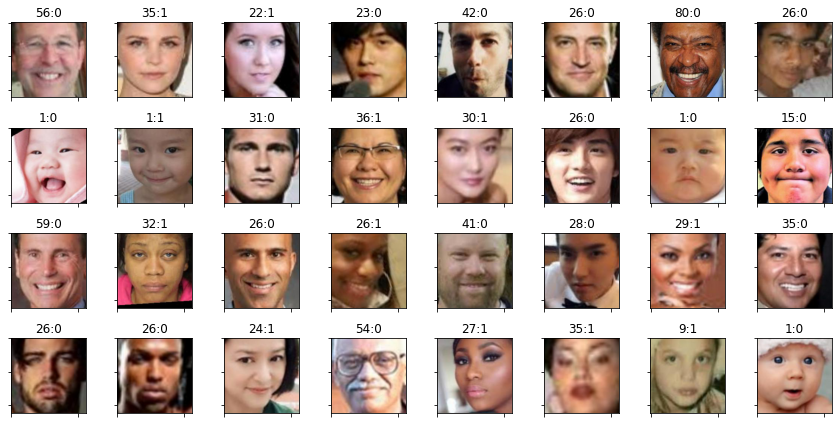

x shape=torch.Size([32, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([32]) dtype=torch.int32


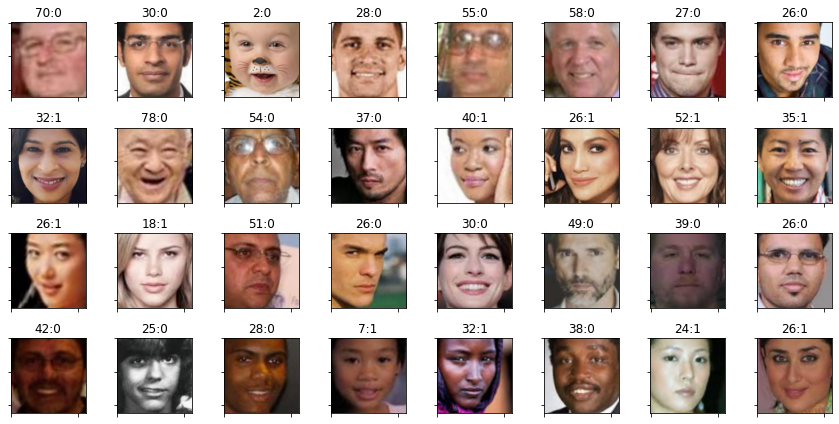

In [8]:
# creamos cargador
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # número de procesos paralelos
    num_workers=0
)
# desplegamos lote
batch = next(iter(trn_dl))
x, y, labels = batch['x'] , batch['age'], batch['gender']
titles = [f'{v}:{l}' for v, l in zip(y, labels)]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, titles, ROWS, COLS)

# creamos cargador
tst_dl = DataLoader(
    # conjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True,
    # número de procesos paralelos
    num_workers=0
)
# desplegamos lote
batch = next(iter(tst_dl))
x, y, labels = batch['x'] , batch['age'], batch['gender']
titles = [f'{v}:{l}' for v, l in zip(y, labels)]
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, titles, ROWS, COLS)

## 2. Analizando la arquitectura a transferir

Torchvision provee una familia de [modelos](https://pytorch.org/vision/stable/models.html#classification) preentrenados en ImageNet. Los desarrolladores cuidan que los modelos sean entrenados con prácticas estándar y reproducibles. Una buena alternativa es el paquete [`tim`](https://github.com/rwightman/pytorch-image-models) de fast.ai.

Usaremos [Shufflenet V2](https://arxiv.org/abs/1807.11164), una arquitectura eficiente para clasificación de imágenes.

In [9]:
model = tvm.shufflenet_v2_x0_5()
print(summary(model, (1, 3, IMG_SIZE, IMG_SIZE),
        col_names=['input_size', 'output_size'],
        device='cpu', verbose=0))


Layer (type:depth-idx)                   Input Shape               Output Shape
ShuffleNetV2                             --                        --
├─Sequential: 1-1                        [1, 3, 224, 224]          [1, 24, 112, 112]
│    └─Conv2d: 2-1                       [1, 3, 224, 224]          [1, 24, 112, 112]
│    └─BatchNorm2d: 2-2                  [1, 24, 112, 112]         [1, 24, 112, 112]
│    └─ReLU: 2-3                         [1, 24, 112, 112]         [1, 24, 112, 112]
├─MaxPool2d: 1-2                         [1, 24, 112, 112]         [1, 24, 56, 56]
├─Sequential: 1-3                        [1, 24, 56, 56]           [1, 48, 28, 28]
│    └─InvertedResidual: 2-4             [1, 24, 56, 56]           [1, 48, 28, 28]
│    │    └─Sequential: 3-1              [1, 24, 56, 56]           [1, 24, 28, 28]
│    │    └─Sequential: 3-2              [1, 24, 56, 56]           [1, 24, 28, 28]
│    └─InvertedResidual: 2-5             [1, 48, 28, 28]           [1, 48, 28, 28]
│    │    └─

C:\Users\sam24\.conda\envs\machine_learning\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


### 2.1 Remplazando la etapa de clasificación

En este caso la etapa de clasificación es solo la capa `model.fc`.


In [10]:
# Empaquetemos la preparación de la arquitectura en una función.
def shufflenet_v2_x0_5(pretrained=True, num_classes=1, freeze_params_buffers=True):
    # instancia e inicilización
    model = tvm.shufflenet_v2_x0_5(pretrained=pretrained)
    if freeze_params_buffers:
        # congelamos los parámetros
        for param in model.parameters():
            # no participa en la retropropagación
            param.requires_grad = False
        # congelamos las estadísticas
        model.eval()
    # remplazo de última capa
    model.fc = nn.Linear(1024, num_classes)
    return model

## 3 Realizando tranferencia

### 3.3 Ciclio de entrenamiento

En este caso estamos aprovechando que ShuffleNet V2 no tiene capas de deserción y solo tiene una capa de regresión para simplificar el ciclo de entrenamiento.
Usamos el error cuadrado medio (MSE) como pérdida para entrenar el modelo.

In [20]:
def train_epoch(dl, model, opt, device):
    """Entrena una época"""
    # entrenamiento de una época
    for batch in dl:
        x = batch['x'].to(device)
        y_true = batch['age'].to(device)
        # computamos salida
        y_pred = model(x)
        # computamos la pérdida
        loss = F.mse_loss(torch.reshape(y_pred, (-1,)),
                          torch.reshape(y_true.float(), (-1,)))
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, device, num_batches=None):
    """Evalua una época"""
    # evitamos que se registren las operaciones
    # en la gráfica de cómputo
    with torch.no_grad():

        losses, accs = [], []
        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for batch in take(dl, num_batches):
            x = batch['x'].to(device)
            y_true = batch['age'].to(device)
            # hacemos inferencia para obtener los logits
            y_pred = model(x)
            # computamos la pérdida
            y_pred = torch.reshape(y_pred, (-1,))
            y_true = torch.reshape(y_true.float(), (-1,))

            loss = F.mse_loss(torch.reshape(y_pred, (-1,)),
                              torch.reshape(y_true.float(), (-1,)))

            # computamos la exactitud
            acc = (y_true == torch.round(y_pred)).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        loss = np.mean(losses)
        acc = np.mean(accs) * 100

        return loss, acc


def save_check_point(model, epoch, run_dir):
    # print('saving best model chkpt in epoch {}'.format(epoch))
    """Guarda un punto de control."""
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
        },
        join(run_dir, 'weights.pth')
    )


def train(model, trn_dl, val_dl,
          trn_writer, val_writer, epochs, run_dir,
          trn_batches=None, val_batches=None):

    # optimizador
    opt = optim.Adam(model.parameters(), lr=1e-3)

    # usamos GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # movemos a dispositivo
    model.to(device)

    # modelo en modo de evaluación
    # para transferencia de conocimiento además de congelar los pesos,
    # es importante congelar las estadísticas σ y μ
    model.eval()

    # ciclo de entrenamiento
    best_loss = 100000

    losses, accs = [], []
    for epoch in tqdm(range(epochs)):

        # entrenamos la época
        train_epoch(trn_dl, model, opt, device)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, device, trn_batches)

        # registramos trazas de TB
        trn_writer.add_scalar('metrics/loss', trn_loss, epoch)
        trn_writer.add_scalar('metrics/acc', trn_acc, epoch)

        # evaluamos la época en validación
        val_loss, val_acc = eval_epoch(val_dl, model, device, val_batches)

        # registramos trazas de TB
        val_writer.add_scalar('metrics/loss', val_loss, epoch)
        val_writer.add_scalar('metrics/acc', val_acc, epoch)

        # pseudo paro temprano: si hay mejora guardamos punto de control
        if val_loss < best_loss:
            best_loss = val_loss
            save_check_point(model, epoch, run_dir)

        losses.append([trn_loss, val_loss])
        accs.append([trn_acc, val_acc])

    return losses, accs


def train_model(trn_dl, tst_dl, pretrained=True, epochs=20):
    # directorio de la corrida
    run_dir = join('runs', 'utkfaces', timestamp())

    # escritor de trazas
    trn_writer = SummaryWriter(join(run_dir, 'trn'))
    val_writer = SummaryWriter(join(run_dir, 'val'))

    # tensorboard --logdir src/tareas/t2/notebooks/runs/utkfaces
    # instanciamos modelo con pesos
    model = shufflenet_v2_x0_5(pretrained=pretrained)
    # entrenamos modelo
    losses, accs = train(model, trn_dl, tst_dl, trn_writer, val_writer, run_dir=run_dir,
          epochs=epochs, trn_batches=5, val_batches=5)

    return run_dir, losses, accs

def load_and_test_model(trn_dl, tst_dl, run_dir):

    # cargamos el punto de contral
    ckpt = torch.load(join(run_dir, 'weights.pth'))
    # imprimimos la mejor época
    best_epoch = ckpt['epoch']
    print(f'Best epoch {best_epoch}')

    # instanciamos un modelo
    model = shufflenet_v2_x0_5()

    # cargamos pesos
    state_dict = ckpt['model_state_dict']
    model.load_state_dict(state_dict)

    # congelamos las estadísticas
    model.eval()
    epoch = ckpt['epoch']
    print(f'Cargamos el mejor modelo, época {epoch}.')


     # Evaluación Final
    device = torch.device('cpu')
    trn_loss, trn_acc = eval_epoch(trn_dl, model, device)
    tst_loss, tst_acc = eval_epoch(tst_dl, model, device)

    print(f'accuracy: trn={trn_acc:5.2f} tst={tst_acc:5.2f}')
    print(f'loss trn={trn_loss:6.2f} tst={tst_loss:6.2f}')


    # Inspección visual de resultados
    with torch.no_grad():
        batch = next(iter(tst_dl))
        x, y_true = batch['x'], batch['age']
        y_pred = torch.reshape(torch.round(model(x)).int(), (-1,))
        titles = [f'T={t} P={p}' for t, p in zip(y_true, y_pred)]
        display_batch(x, titles, ROWS, COLS)

### 3.1 Entrenamiento y prueba
Se genera un directorio automático para guardar la corrida y en formatos comopatibles con Tensorboard.

Primero entrenamos el model con las capas preentrenadas y 30 épocas

In [21]:
run_dir, losses_pretrained, accs_pretrained = train_model(trn_dl, tst_dl, pretrained=True, epochs=30)

100%|██████████| 30/30 [23:09<00:00, 46.32s/it]


Best epoch 29
Cargamos el mejor modelo, época 29.
accuracy: trn= 3.25 tst= 3.15
loss trn=204.96 tst=199.02


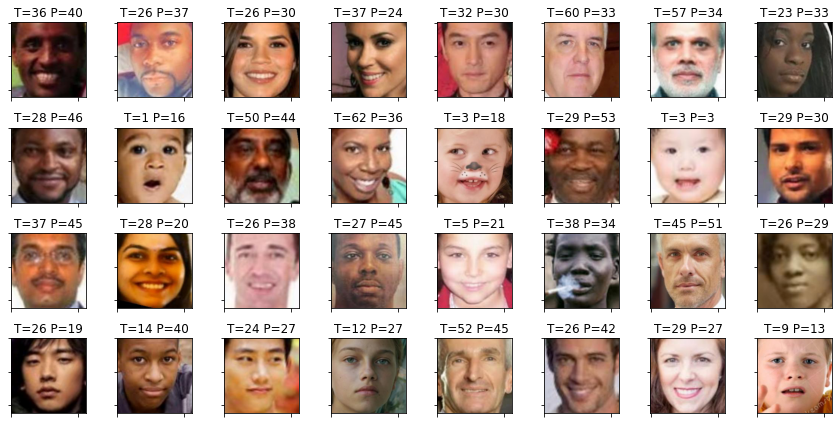

In [22]:
load_and_test_model(trn_dl, tst_dl, run_dir)

Después entrenamos el model sin capas preentrenadas y 30 épocas

In [23]:
run_dir, losses, accs = train_model(trn_dl, tst_dl, pretrained=False, epochs=30)

100%|██████████| 30/30 [20:56<00:00, 41.89s/it]


TypeError: load_and_test_model() missing 2 required positional arguments: 'tst_dl' and 'run_dir'

Best epoch 27
Cargamos el mejor modelo, época 27.
accuracy: trn= 1.06 tst= 0.96
loss trn=702.78 tst=670.65


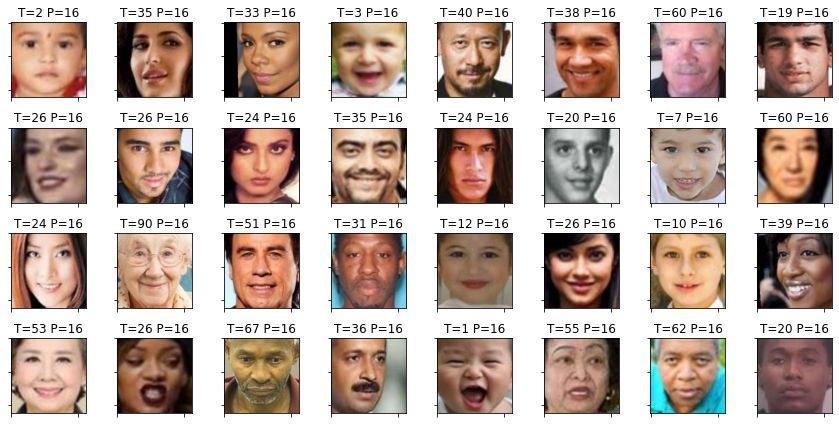

In [24]:
load_and_test_model(trn_dl, tst_dl, run_dir)

Claramente la pérdida es menor en el modelo con capas preentrenadas. <br>
Ahora graficamos la pérdida en el conjunto de prueba para ambos modelos.

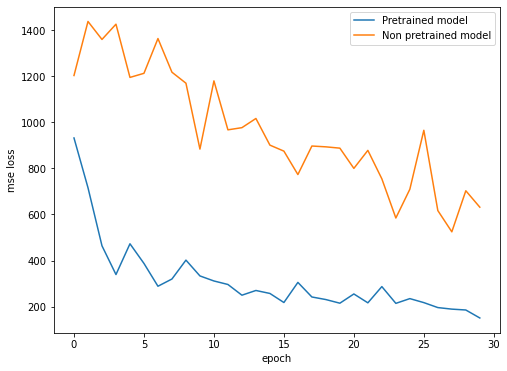

In [25]:
tst_losses_pretrained = np.array(losses_pretrained)[:, 1]
tst_losses = np.array(losses)[:, 1]
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(tst_losses_pretrained, label='Pretrained model')
ax.plot(tst_losses, label='Non pretrained model')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.show()

Como era de esperarse, el modelo con capas pre entrenadas, tiene un
mejor desempeño que entrenando el modelo desde cero.